In [11]:
# -*- coding: utf-8 -*-

import scipy.io
import numpy as np
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
import itertools
import random

from numba import cuda
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import  EarlyStopping

In [12]:
# tensorflow = 2.
# python = 3.6


seed = np.random.seed(777)

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    
  try:
      
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
  except RuntimeError as e:
      
    print(e)


val_loss_all = []

test_loss_all = []
test_acc_all = []
test_pre_all = []
frr_all = []
far_all = []

conf_matrix_sco = []
test_pre_sco = []
test_rec_sco = []
test_spedi_sco = []
test_sensi_sco = []

class MyModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):

    def __init__(self, *args, **kwargs):
        super(MyModelCheckpoint, self).__init__(*args, **kwargs)

    # redefine the save so it only activates after 100 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch >= 1: super(MyModelCheckpoint, self).on_epoch_end(epoch, logs)

In [13]:
train_data = scipy.io.loadmat('../../datas/160hz/train_5day_160hz.mat', squeeze_me=True)['data']
test_data = scipy.io.loadmat('../../datas/160hz/test_6day_160hz(2).mat', squeeze_me=True)['data']

# sub 수
sub_cnt = train_data.shape[0]

# 3sec 데이터 크기
data_size = 480

# 1명당 3초 데이터 개수
train_data_cnt = 1052
test_data_cnt = 211

# 3sec 480(= 160*3) 크기로 데이터 길이 설정
train_cut_size = 504960 # 480*1052 = 504960
test_cut_size = 101280 # 480*211 = 101280

# 3sec 데이터 길이 자르기
# train: 504,960 / test: 101,280
train_data = train_data[:,0:train_cut_size,:]
test_data = test_data[:,0:test_cut_size,:]

# flatten(): 3D -> 1D / reshape(-1,1): -1 마지막 인덱스
train_flatten = train_data.flatten().reshape(-1,1)
test_flatten = test_data.flatten().reshape(-1,1)

# StandardScaler(): train에 맞춰 표준화
data_scaler = StandardScaler()
    
data_scaler.fit(train_flatten)
train_scaler = data_scaler.transform(train_flatten)
test_scaler = data_scaler.transform(test_flatten)
    
# train, test 데이터 reshape
train_data = train_scaler.reshape(train_data_cnt * sub_cnt, data_size, 2) 
test_data = test_scaler.reshape(test_data_cnt * sub_cnt, data_size, 2)

#train data를 sub:other=1:1로 만들기 위해서 각 sub 추출
train_data_each = []
for i in range(sub_cnt):
    train_data_each.insert(i, train_data[i*train_data_cnt:(i+1)*train_data_cnt, :, :])
print(np.shape(train_data_each))

#test data를 sub:other=1:3로 만들기 위해서 각 sub 추출
test_data_each = []
for i in range(sub_cnt):
    test_data_each.insert(i, test_data[i*test_data_cnt:(i+1)*test_data_cnt, :, :])
print(np.shape(test_data_each))

(11, 1052, 480, 2)
(11, 211, 480, 2)


In [14]:
# sub number
sub_num = 2

#1 to 3 비율로 설정
ratio = 3

train_data_n = train_data_each[sub_num]
test_data_n = test_data_each[sub_num]

# train data를 sub:other = 1:3으로 만들기
# 3초 덩어리 개수 1052 : 3156
# => 315 * 4 + 316 * 6 = 1260 + 1896 = 3156

# test data를 sub:other = 1:3로 만들기
# 3초 덩어리 개수 211 : 633
# 63 * 7 + 64 * 3 = 633

cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 4:
        cnt = cnt + 1
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 315)), axis = 0)
    elif j != sub_num and cnt >= 4:
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 316)), axis = 0)
#     print("train_data_n.shape")
#     print(train_data_n.shape)
#     print("train_data_n")
#     print(train_data_n)
        
cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 7:
        cnt = cnt + 1
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 63)), axis = 0)
    elif j != sub_num and cnt >= 7:
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 64)), axis = 0)
        
        
        
train_label = np.zeros(train_data_cnt*(ratio+1))
test_label = np.zeros(test_data_cnt*(ratio+1))

for j in range(len(train_label)):
    if (j < train_data_cnt):
        train_label[j] = 1

for j in range(len(test_label)):
    if (j < test_data_cnt):
        test_label[j] = 1
        
train_data_shuffled, train_label_shuffled = sk.utils.shuffle(train_data_n, train_label, random_state = 0)

val_data_set = train_data_shuffled[:train_data_cnt]
train_data_set = train_data_shuffled[train_data_cnt:]

val_label_set = train_label_shuffled[:train_data_cnt]
train_label_set = train_label_shuffled[train_data_cnt:]
  

Epoch 1/200
99/99 [==============================] - 2s 24ms/step - loss: 0.5768 - accuracy: 0.7475 - val_loss: 0.5425 - val_accuracy: 0.7367
Epoch 2/200
97/99 [============================>.] - ETA: 0s - loss: 0.4498 - accuracy: 0.7738
Epoch 00002: val_loss improved from inf to 0.38717, saving model to best_model_3.h5
99/99 [==============================] - 2s 21ms/step - loss: 0.4495 - accuracy: 0.7741 - val_loss: 0.3872 - val_accuracy: 0.7757
Epoch 3/200
97/99 [============================>.] - ETA: 0s - loss: 0.3740 - accuracy: 0.8051
Epoch 00003: val_loss improved from 0.38717 to 0.36682, saving model to best_model_3.h5
99/99 [==============================] - 2s 21ms/step - loss: 0.3734 - accuracy: 0.8064 - val_loss: 0.3668 - val_accuracy: 0.8289
Epoch 4/200
97/99 [============================>.] - ETA: 0s - loss: 0.3504 - accuracy: 0.8238
Epoch 00004: val_loss improved from 0.36682 to 0.33474, saving model to best_model_3.h5
99/99 [==============================] - 2s 21ms/step

Epoch 29/200
97/99 [============================>.] - ETA: 0s - loss: 0.1591 - accuracy: 0.9385
Epoch 00029: val_loss did not improve from 0.16353
99/99 [==============================] - 2s 21ms/step - loss: 0.1576 - accuracy: 0.9388 - val_loss: 0.2047 - val_accuracy: 0.9183
Epoch 30/200
97/99 [============================>.] - ETA: 0s - loss: 0.1685 - accuracy: 0.9359
Epoch 00030: val_loss did not improve from 0.16353
99/99 [==============================] - 2s 21ms/step - loss: 0.1681 - accuracy: 0.9357 - val_loss: 0.1896 - val_accuracy: 0.9173
Epoch 31/200
97/99 [============================>.] - ETA: 0s - loss: 0.1649 - accuracy: 0.9359
Epoch 00031: val_loss did not improve from 0.16353
99/99 [==============================] - 2s 21ms/step - loss: 0.1641 - accuracy: 0.9360 - val_loss: 0.2037 - val_accuracy: 0.9183
Epoch 32/200
97/99 [============================>.] - ETA: 0s - loss: 0.1494 - accuracy: 0.9439
Epoch 00032: val_loss did not improve from 0.16353
99/99 [===============

Epoch 58/200
97/99 [============================>.] - ETA: 0s - loss: 0.1076 - accuracy: 0.9575
Epoch 00058: val_loss did not improve from 0.13615
99/99 [==============================] - 2s 21ms/step - loss: 0.1079 - accuracy: 0.9575 - val_loss: 0.1480 - val_accuracy: 0.9401
Epoch 59/200
97/99 [============================>.] - ETA: 0s - loss: 0.1121 - accuracy: 0.9523
Epoch 00059: val_loss did not improve from 0.13615
99/99 [==============================] - 2s 21ms/step - loss: 0.1114 - accuracy: 0.9528 - val_loss: 0.2116 - val_accuracy: 0.9183
Epoch 60/200
97/99 [============================>.] - ETA: 0s - loss: 0.1051 - accuracy: 0.9588
Epoch 00060: val_loss improved from 0.13615 to 0.12724, saving model to best_model_3.h5
99/99 [==============================] - 2s 21ms/step - loss: 0.1053 - accuracy: 0.9585 - val_loss: 0.1272 - val_accuracy: 0.9544
Epoch 61/200
97/99 [============================>.] - ETA: 0s - loss: 0.1090 - accuracy: 0.9562
Epoch 00061: val_loss did not improv

33/33 - 0s - loss: 0.1272 - accuracy: 0.9544
27/27 - 0s - loss: 0.1691 - accuracy: 0.9277


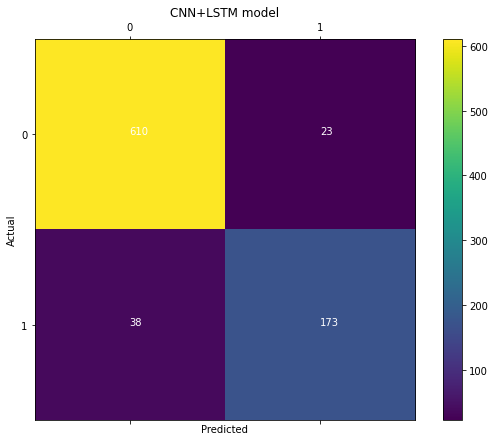

val_loss: 0.1272442638874054
test_loss: 0.16911330819129944
test_acc: 0.9277251362800598
precision: 0.8826530612244898
recall: 0.8199052132701422
specificity 0.9636650868878357
sensitivity :  0.8199052132701422
far 0.036334913112164295
frr 0.18009478672985782


In [15]:
# model CNN-LSTM    
inputs = tf.keras.Input(shape = (480, 2))
conv_1 = tf.keras.layers.Conv1D(filters = 183, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(inputs)
max_1 = tf.keras.layers.MaxPool1D(3)(conv_1)
    
conv_2 = tf.keras.layers.Conv1D(filters = 63, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_1)
max_2 = tf.keras.layers.MaxPool1D(3)(conv_2)
    
conv_3 = tf.keras.layers.Conv1D(filters = 21, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_2)
max_3 = tf.keras.layers.MaxPool1D(3)(conv_3)
    

D_out_1 = tf.keras.layers.Dropout(0.5825123831711266)(max_3)
    
    
lstm_1 = tf.keras.layers.LSTM(108)(D_out_1)
    
dense_1 = tf.keras.layers.Dense(148, activation = 'relu')(lstm_1)
dense_2 = tf.keras.layers.Dense(10, activation = 'relu')(dense_1)
# dense_3 = tf.keras.layers.Dense(139, activation = 'relu')(dense_2)
dense_4 = tf.keras.layers.Dense(1, activation = 'sigmoid')(dense_2)
    
model = tf.keras.models.Model(inputs = inputs, outputs = dense_4)

# Adam
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.00014136930875531704), metrics = ['accuracy'])
# SGD
# model.compile(loss= 'binary_crossentropy', optimizer= tf.keras.optimizers.SGD(learning_rate=0.0461300729767683, momentum=0.4411297369087802), metrics=['accuracy'])
    
# EarlyStopping 조기종료 및 모델 학습
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 20)
check_point = MyModelCheckpoint('best_model_' + str(sub_num + 1) + '.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

# EarlyStopping 사용
hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [early_stopping, check_point])
# EarlyStopping 미사용
# hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [check_point])

# model save .h5형식
model = tf.keras.models.load_model('best_model_' + str(sub_num + 1) + '.h5')
model.save('Binary_BOHB_' + str(sub_num + 1) + '.h5')
model.summary() 
        
val_loss, val_acc = model.evaluate(val_data_set, val_label_set, verbose = 2)

test_loss, test_acc = model.evaluate(test_data_n, test_label, verbose = 2)
test_pred = model.predict(test_data_n)
        
    
# 각 행은 1sec, 0.5 <= 자신, 0.5 > 타인
for i in range(len(test_pred)):
    if(test_pred[i] >= 0.5):
        test_pred[i] = 1
    
    else: 
        test_pred[i] = 0
    
    
val_loss_all.append(val_loss)
    
test_loss_all.append(test_loss)
test_acc_all.append(test_acc)
test_pre_all.append(test_pred)
    

conf_matrix = confusion_matrix(test_label, test_pred) 
conf_matrix_sco.append(conf_matrix)
    
conf_row = conf_matrix.sum(axis = 1)
conf_col = conf_matrix.sum(axis = 0)

precision = conf_matrix[1][1] / conf_col[1]
recall = conf_matrix[1][1] / conf_row[1]
specificity = conf_matrix[0][0] / conf_row[0]
sensitivity = conf_matrix[1][1] / conf_row[1]
frr = conf_matrix[1][0] / (conf_matrix[1][1]+conf_matrix[1][0])
far = conf_matrix[0][1] / (conf_matrix[0][1]+conf_matrix[0][0])
    
frr_all.append(frr)
far_all.append(far)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

cax = ax.matshow(conf_matrix)

fig.colorbar(cax)

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], color="white")

plt.title('CNN+LSTM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()
 
    
test_pre_sco.append(precision)
test_rec_sco.append(recall)
test_spedi_sco.append(specificity)
test_sensi_sco.append(sensitivity)
    
print('val_loss:', val_loss)
print('test_loss:', test_loss)
print('test_acc:', test_acc)
    
print('precision:', precision)
print('recall:', recall)
print('specificity', specificity)
print('sensitivity : ', sensitivity)
print('far', far)
print('frr', frr)